
## Appendix D: Constructing MetaShift from COCO Dataset
The notebook `dataset/extend_to_COCO/coco_MetaShift.ipynb` reproduces the COCO subpopulation shift dataset in paper Appendix D. Executing the notebook would construct a “Cat vs. Dog” task based on COCO images, where the “indoor/outdoor” contexts are spuriously correlated with the class labels. 

### Install COCO Dependencies
Install pycocotools (for evaluation on COCO):
```
conda install cython scipy
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
```

### COCO Data preparation

[2017 Train/Val annotations [241MB]](http://images.cocodataset.org/annotations/annotations_trainval2017.zip)

[2017 Train images [118K/18GB]](http://images.cocodataset.org/zips/train2017.zip)

Download and extract COCO 2017 train and val images with annotations from
[http://cocodataset.org](http://cocodataset.org/#download).
We expect the directory structure to be the following:
```
/home/ubuntu/data/coco/
  annotations/  # annotation json files
  train2017/    # train images
  val2017/      # val images
```

### Output files

The following files will be generated by executing the notebook. 
```plain
/data/MetaShift/COCO-Cat-Dog-indoor-outdoor
├── imageID_to_group.pkl
├── train/
    ├── cat/
    ├── dog/ 
├── val_out_of_domain/
    ├── cat/
    ├── dog/ 
```
where `imageID_to_group.pkl` is a dictionary with 4 keys : 
`'cat(outdoor)'`, `'cat(outdoor)'`, `'dog(outdoor)'`, `'dog(outdoor)'`. 
The corresponding value of each key is the list of the names of the images that belongs to that subset.  

### Cat vs. Dog Task with indoor/outdoor contexts
We construct a “Cat vs. Dog” task, where the “indoor/outdoor” contexts are spuriously correlated with the class labels. The “indoor” context is constructed by merging the following super-categories: 'indoor', 'kitchen', 'electronic', 'appliance', 'furniture'. Similarly, the “outdoor” context is constructed by merging the following super-categories: 'outdoor', 'vehicle', 'sports'. 

In addition, in the training data, cat(ourdoor) and dog(indoor) subsets are the minority groups, while cat(indoor) and dog(outdoor) are majority groups. 

We keep the total size of training data as 3000 images unchanged and only vary the portion of minority groups. 
We use a balanced test set with 524 (131*4) images to report both average accuracy and worst group accuracy. 

In [1]:
# The source COCO images; replace with the path to your COCO 
IMAGE_DATA_FOLDER = '/home/ubuntu/data/coco/train2017/' 

# The folder to generate COCO
CUSTOM_SPLIT_DATASET_FOLDER = '/data/MetaShift/COCO-Cat-Dog-indoor-outdoor'


In [11]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import random
import pickle
import numpy as np
import json, re, math
from collections import Counter, defaultdict
import pprint
import networkx as nx # graph vis
import pandas as pd


In [3]:
dataDir='/home/ubuntu/data/coco' # replace with your COCO 2017 data dir
dataType='train2017'
# dataType='val2017' # Only for debug
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=23.59s)
creating index...
index created!


In [4]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
# print('cats[0]', cats[0])
nms=[cat['name'] for cat in cats]
print('COCO {} categories: \n{}\n'.format(len(nms), ' '.join(nms)), )
category_nms = nms

nms = set([cat['supercategory'] for cat in cats])
print('COCO {} supercategories: \n{}'.format(len(nms), ' '.join(nms)))
supercategory_nms = nms

COCO 80 categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO 12 supercategories: 
indoor person accessory vehicle appliance animal sports furniture outdoor food electronic kitchen


In [5]:
# Compare with Visaul Genome based MetaDataset
def load_candidate_subsets():
    pkl_save_path = "../meta_data/full-candidate-subsets.pkl" 
    with open(pkl_save_path, "rb") as pkl_f:
        load_data = pickle.load( pkl_f )
        print('pickle load', len(load_data), pkl_save_path)
    return load_data

VG_node_name_to_img_id = load_candidate_subsets()

pickle load 17938 ../meta_data/full-candidate-subsets.pkl


## Fetch Example COCO Image

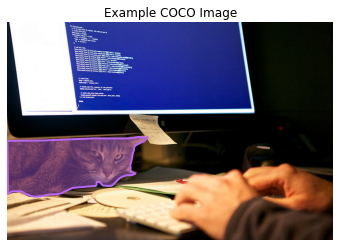

In [6]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['cat'])
imgIds = coco.getImgIds(catIds=catIds )
imgIds = coco.getImgIds(imgIds = imgIds[:20]) # in val
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

# load and display instance annotations
I = io.imread(img['coco_url'])
plt.imshow(I); 
plt.axis('off')
plt.title('Example COCO Image')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)


# Plan

Based on super categories, identify two (mostly) disjoint partitions. 
let's say indoor, outdoor. 

and then suriously correlating with two classes. 

In [7]:
# Construct indoor/outdoor categories. 
cats = coco.loadCats(coco.getCatIds())
outdoor_categories = [ cat['name'] for cat in cats if cat['supercategory'] in ['outdoor', 'vehicle', 'sports'] ]
indoor_categories = [ cat['name'] for cat in cats if cat['supercategory'] in ['indoor', 'kitchen', 'electronic', 'appliance', 'furniture' ] ]

# display COCO categories and supercategories
print('The following categories are considered as outdoor contexts:\n', outdoor_categories)
print()
print('The following categories are considered as indoor contexts:\n', indoor_categories)

The following categories are considered as outdoor contexts:
 ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket']

The following categories are considered as indoor contexts:
 ['bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [8]:
size_array = list()
node_name_set = set()
class_set = set()

for subject_idx_i in range(len(category_nms)):
    for subject_idx_j in range(subject_idx_i+1, len(category_nms)):
        nms_i = category_nms[subject_idx_i]
        nms_j = category_nms[subject_idx_j]
        catIds = coco.getCatIds(catNms=[nms_i, nms_j])
        imgIds = coco.getImgIds(catIds=catIds )
        if len(imgIds)>=25: # only consider the subsets that are large enough (with >=25 images)
            size_array.append(len(imgIds))
            node_name_set.add(nms_i + '(' + nms_j + ')')
            class_set.add(nms_i)
            class_set.add(nms_j)


print('size_array mean:', np.mean(size_array), 'median:', np.median(size_array), 'num of subsets:', len(size_array) )

shared_subset_names = node_name_set.intersection(set(VG_node_name_to_img_id.keys()))
print('COCO subsets overlap with VG', len(shared_subset_names), 'ratio:', len(shared_subset_names)/len(node_name_set) )

print('Number of metagraph', len(class_set))


size_array mean: 389.5866767600303 median: 124.0 num of subsets: 1321
COCO subsets overlap with VG 511 ratio: 0.38682816048448143
Number of metagraph 80


In [9]:
# draw meta-graph for cat. 
node_name_to_img_id = dict() # cat(xxx)
subject_str = 'cat'
subject_node_name_set = [x for x in node_name_set if subject_str + '(' in x] # equivalent to: subject_most_common_list
subject_node_name_set = set(subject_node_name_set) - {'cat(clock)', 'cat(tie)', 'cat(dog)', 'cat(teddy bear)', 'cat(scissors)'}
subject_node_name_set = sorted(subject_node_name_set)
print('subject_str', subject_str, 'subject_node_name_set', subject_node_name_set)
for node_name in subject_node_name_set: 
    # parse object
    context_obj_tag = node_name.split('(')[-1][:-1]
    imgIds = coco.getImgIds(catIds=coco.getCatIds(catNms=[context_obj_tag]) )
    node_name_to_img_id[node_name] = set(imgIds)

subject_str cat subject_node_name_set ['cat(apple)', 'cat(backpack)', 'cat(banana)', 'cat(bed)', 'cat(book)', 'cat(bottle)', 'cat(bowl)', 'cat(cell phone)', 'cat(chair)', 'cat(couch)', 'cat(cup)', 'cat(dining table)', 'cat(handbag)', 'cat(keyboard)', 'cat(knife)', 'cat(laptop)', 'cat(microwave)', 'cat(mouse)', 'cat(oven)', 'cat(potted plant)', 'cat(refrigerator)', 'cat(remote)', 'cat(sink)', 'cat(spoon)', 'cat(suitcase)', 'cat(toilet)', 'cat(toothbrush)', 'cat(tv)', 'cat(umbrella)', 'cat(vase)', 'cat(wine glass)']


## Indoor/Outdoor Cat/Dog Subpopulation Shifts

In [19]:
# Explore cat/dog indoor/outdoor

def union_imgIds_cateogry_list(list_categories):
    union_imgIds = set()
    for category in list_categories:
        imgIds = coco.getImgIds(catIds=coco.getCatIds(catNms=[category]) )
        union_imgIds.update(imgIds)
    return union_imgIds

def pad_str_imageID_list(imageID_list):
    ret = [coco.loadImgs([x])[0]["file_name"].replace('.jpg', '') for x in imageID_list]
    ret_set = set(ret)
    return ret_set

outdoor_imgIds = union_imgIds_cateogry_list(list_categories = outdoor_categories)
indoor_imgIds  = union_imgIds_cateogry_list(list_categories = indoor_categories)
outdoor_imgIds = pad_str_imageID_list(outdoor_imgIds)
indoor_imgIds  = pad_str_imageID_list(indoor_imgIds)
ambiguous_imdIds = outdoor_imgIds.intersection(indoor_imgIds)
outdoor_imgIds -= ambiguous_imdIds
indoor_imgIds  -= ambiguous_imdIds

cat_imgIds = set(coco.getImgIds(catIds=coco.getCatIds(catNms=['cat']) ))
dog_imgIds = set(coco.getImgIds(catIds=coco.getCatIds(catNms=['dog']) ))
cat_imgIds = pad_str_imageID_list(cat_imgIds)
dog_imgIds = pad_str_imageID_list(dog_imgIds)

cat_outdoor_imgIds = cat_imgIds.intersection(outdoor_imgIds)
cat_indoor_imgIds  = cat_imgIds.intersection(indoor_imgIds)
dog_outdoor_imgIds = dog_imgIds.intersection(outdoor_imgIds)
dog_indoor_imgIds  = dog_imgIds.intersection(indoor_imgIds)


print(
    '\n Total number of cat(outdoor) images', len(cat_outdoor_imgIds),
    '\n Total number of cat(indoor) images', len(cat_indoor_imgIds),
    '\n Total number of dog(outdoor) images', len(dog_outdoor_imgIds),
    '\n Total number of dog(indoor) images', len(dog_indoor_imgIds),
    ) 



 Total number of cat(outdoor) images 331 
 Total number of cat(indoor) images 2707 
 Total number of dog(outdoor) images 1586 
 Total number of dog(indoor) images 1500


In [13]:
import os
import shutil # for copy files

##################################
# Copy Images specified by IDs: 
# destination folder: os.path.join(root_folder, split, subset_str)
##################################
def copy_images(root_folder,  split, subset_str, img_IDs, use_symlink=True):
    ##################################
    # Create dataset a new folder 
    ##################################
    subject_localgroup_folder = os.path.join(root_folder, split, subset_str)
    if os.path.isdir(subject_localgroup_folder): 
        shutil.rmtree(subject_localgroup_folder) 
    os.makedirs(subject_localgroup_folder, exist_ok = False)

    for image_idx_in_set, imageID in enumerate(img_IDs): 
        src_image_path = IMAGE_DATA_FOLDER + imageID + '.jpg' 
        dst_image_path = os.path.join(subject_localgroup_folder, imageID + '.jpg') 

        if use_symlink:
            ##################################
            # Image Copy Option B: create symbolic link
            # Usage: for local use, saving disk storge. 
            ##################################
            # need to assert existance. 
            assert os.path.isfile(src_image_path), src_image_path
            os.symlink(src_image_path, dst_image_path)
            # print('symlink:', src_image_path, dst_image_path)
        else:
            ##################################
            # Image Copy Option A: copy the whole jpg file
            # Usage: for sharing the meta-dataset
            ################################## 
            shutil.copyfile(src_image_path, dst_image_path)
            # print('copy:', src_image_path, dst_image_path)
    return 



In [14]:
if os.path.isdir(CUSTOM_SPLIT_DATASET_FOLDER): 
    shutil.rmtree(CUSTOM_SPLIT_DATASET_FOLDER) 
os.makedirs(CUSTOM_SPLIT_DATASET_FOLDER, exist_ok = False)

import random
def shuffle_and_truncate(img_id_set, truncate=500):
    img_id_list = sorted(img_id_set)
    random.Random(42).shuffle(img_id_list)
    return img_id_list[:truncate]


cat_outdoor_images = shuffle_and_truncate(cat_outdoor_imgIds, 331) # 131 for test, 0-200 for training
dog_indoor_images  = shuffle_and_truncate(dog_indoor_imgIds, 331) 
cat_indoor_images  = shuffle_and_truncate(cat_indoor_imgIds, 1500) 
dog_outdoor_images = shuffle_and_truncate(dog_outdoor_imgIds, 1500) 

from sklearn.model_selection import train_test_split
cat_outdoor_train, cat_outdoor_test, dog_indoor_train, dog_indoor_test = train_test_split(cat_outdoor_images, dog_indoor_images, test_size=131, random_state=42)
cat_indoor_train, cat_indoor_test, dog_outdoor_train, dog_outdoor_test = train_test_split(cat_indoor_images, dog_outdoor_images, test_size=131, random_state=42)

# plan: 1500 training, 
NUM_MINORITY_IMG = 200 # 15-200/1500: 15(1%), 100(7%), 200(13%)

copy_images(
    CUSTOM_SPLIT_DATASET_FOLDER, 'val_out_of_domain', 'cat', use_symlink=True,
    img_IDs = cat_outdoor_test + cat_indoor_test,
    )
copy_images(
    CUSTOM_SPLIT_DATASET_FOLDER, 'val_out_of_domain', 'dog', use_symlink=True,
    img_IDs = dog_indoor_test + dog_outdoor_test,
    )

copy_images(
    CUSTOM_SPLIT_DATASET_FOLDER, 'train', 'cat', use_symlink=True,
    img_IDs = cat_outdoor_train[:NUM_MINORITY_IMG] + cat_indoor_train[NUM_MINORITY_IMG:],
    )
copy_images(
    CUSTOM_SPLIT_DATASET_FOLDER, 'train', 'dog', use_symlink=True,
    img_IDs = dog_indoor_train[:NUM_MINORITY_IMG] + dog_outdoor_train[NUM_MINORITY_IMG:],
    )
print('NUM_MINORITY_IMG', NUM_MINORITY_IMG)

NUM_MINORITY_IMG 200


In [15]:
##################################
# Book-keeping structure
##################################
with open(CUSTOM_SPLIT_DATASET_FOLDER + '/' + 'imageID_to_group.pkl', 'wb') as handle:
    imageID_to_group = dict()
    group_to_imageID = {
        'cat(outdoor)': cat_outdoor_images,
        'dog(indoor)': dog_indoor_images,
        'cat(indoor)': cat_indoor_images,
        'dog(outdoor)': dog_outdoor_images,
    }
    for group_str in group_to_imageID:
        for imageID in group_to_imageID[group_str]:
            imageID_to_group[imageID] = [group_str] 
    pickle.dump(imageID_to_group, file=handle)



## All done! 

In [17]:
print('All done!')
print('please check your destination folder', CUSTOM_SPLIT_DATASET_FOLDER)

All done!
please check your destination folder /data/MetaShift/COCO-Cat-Dog-indoor-outdoor
